In [ ]:
  
# SKT Brain의 KoBERT, 학습 및 테스트 데이터셋만 따로 준비 = 카카오 브런치[text, label]
# SKT Brain github 주소는 다음과 같습니다. https://github.com/SKTBrain/KoBERT

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2 # 최신 버전으로 설치하면 "Input: must be Tensor, not str" 라는 에러 발생
!pip install torch

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

     |████████████████████████████████| 47.3 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 7.4 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595737 sha256=e728cb1ff1898f8b41231c614160dfdbf6f1d168fda7fb9c1b1d011d47ac4304
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 9.9 MB/s 
     |████████████████████████████████| 769 kB 8.6 MB/s 
     |████████████████████████████████| 3.0 MB 66.2 MB/s 
     |████████████████████████████████| 895 kB 69.8 MB/s 
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-t6ck7oz9
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pi

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
# GPU 사용 시
device = torch.device("cuda:0")

# BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

.cache/kobert_v1.zip[██████████████████████████████████████████████████]
.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터셋 불러오기
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/데캡디/review_data_1700_1217.csv')

In [ ]:
# data 확인
df.head()

,review,label
0,온 가족이 쓰는 수분크림입니다. 발림성이 좋고 피부에 자극없어서 자주 애용합니다.,0
1,추천추천추천합니다 순해서 자극없고 발림성도 좋아요 수분감도 좋은것같아 맘에듭니다^^,0
2,세안하고나서 수건으로 얼굴의 물기를 닦아내지않고 바로 토너를 사용하고 있어서 저한텐...,0
3,샘플사용해보고 좋아서 본품 구매햇어요 수분크림역할 잘하는 거 같아요 다만 용기가 불...,0
4,수부지 수분크림으로 유명하고 20ml증정해주고 세일해서 구매했어요 아직 사용은안했지...,0


In [ ]:
df.rename(columns={'review':'content', 'label':'label'}, inplace=True)

In [ ]:
df = df.astype({'label':'object'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1578 non-null   object
 1   label    1578 non-null   object
dtypes: object(2)
memory usage: 24.8+ KB


In [ ]:
df['label'].value_counts()

0    1013
1     565
Name: label, dtype: int64

In [ ]:
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]

In [ ]:
df_0 = df_0[:565]
df = pd.concat([df_0, df_1])
df['label'].value_counts()

1    565
0    565
Name: label, dtype: int64

In [ ]:
# label encoding
df.loc[(df['label'] == '0'), 'label'] = 0 
df.loc[(df['label'] == '1'), 'label'] = 1 


# list형태로 데이터 저장 -> [content, label] 형태
data_list = []
for q, label in zip(df['content'], df['label'])  :
    data = []
    data.append(str(q)) # str타입으로 변환, 안 해주면 나중에 타입변환할 때 오류남
    data.append(str(label))

    data_list.append(data)

In [ ]:
df = df.astype({'label':'int'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 0 to 1577
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1130 non-null   object
 1   label    1130 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.5+ KB


In [ ]:
# list형태로 데이터 저장 -> [content, label] 형태
data_list = []
for q, label in zip(df['content'], df['label'])  :
    data = []
    data.append(str(q)) # str타입으로 변환, 안 해주면 나중에 타입변환할 때 오류남
    data.append(str(label))

    data_list.append(data)

In [ ]:
# 데이터 확인
print(data_list[0])
print(data_list[-1])

['온 가족이 쓰는 수분크림입니다. 발림성이 좋고 피부에 자극없어서 자주 애용합니다.', '0']
['가성비 좋고 부담없이 바를수 있던 수분크림이였어요👍🏻 홍조있으신 분들 추천드려요! 피부진정에 너무 좋더라구요ㅎㅎ 여름에 꾸덕꾸덕한 크림은 뭔가 손이 잘안가는데, 라운드랩 자작나무 수분크림은 꾸덕하지 않고 바른 후 엄청 산뜻했어요! 그렇지만 수분감도 충분히 촉촉하게 줘서 마스크때문에 건조함부분이 전~혀 건조하지 않더라구요ㅎㅎ 화장전에 발라도 화장이 밀리지 않고, 피부가 광채 있어 보여서 좋습니다! 제형은 엄청 가볍고 크림안에 캡슐같은게 들어있어서 바를때 톡톡 터지는게 느낌이 좋아요👍🏻 이 크림은 피부타입 건성 지성 수부지 모두 사용해도 괜찮은 굿 같아요! 자극도 없고, 성분도 나쁘지 않은 것 같네용 수분왕패드까지 기획세트여서 여름휴가때 엄청 잘썼어요! 그리고 홍조가 심해서 홍조팩으로도 애용많이 했습니다👏🏻 라운드랩 자작나무 수분크림', '1']


In [ ]:
# train, test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)

In [ ]:
# 데이터 개수 확인
print(len(dataset_train))
print(len(dataset_test))

904
226


In [ ]:
# KoBERT모델의 입력으로 들어갈 수 있는 형태가 되도록 변환해주는 class
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        # BERTSentenceTransform이라는 모듈 사용
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        # 타입 변환
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    # item 가져오기
    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    # 길이 출력
    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 256
batch_size = 16
warmup_ratio = 0.1
num_epochs = 7
max_grad_norm = 1
log_interval = 200
learning_rate =  1e-6

In [ ]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# 패딩
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model


In [ ]:
# 데이터 확인 -> array1은 시퀀스, array2는 길이와 타입, array3은 attention mask 시퀀스(1로 패딩된 값들은 연산할 필요가 없기 때문에, 연산을 하지 않아도 됨 -> 이걸 알려주는 데이터가 바로 얘)
data_train[0]

(array([   2, 2801, 6812, 7788, 5655, 6553, 2872, 5387, 3251, 7095, 2135,
        5573,  517, 5787, 6797, 5678, 7318, 6820, 5439, 2196, 4737, 5691,
        6116, 2613, 7788, 3869, 3990, 7828, 7621, 4737, 5691, 5760, 4918,
        7120,  517,   46, 3093, 5743, 6797, 3220, 6573, 7446,  517,  216,
        2872, 5957, 4737, 5691, 5330,  517, 5960, 3166, 6166, 5760, 4158,
        7119,  905,  832, 6999,  517,    5, 2135, 7234, 7921, 7101,  517,
        5787, 7628, 7789, 6896, 4209, 4158, 7096, 5439,  517, 5330, 5646,
        6792, 7794, 4737, 5691, 7700, 7078, 5859, 3996, 5804, 7782, 5703,
         517,  463, 3698, 2929, 7576, 7700, 7003, 5112, 7178, 6619, 5859,
         834, 2221, 5895, 5761, 5176, 5561, 6903, 3692, 4206, 5760, 1958,
        5938, 1956, 2421, 7330, 5112, 7178, 6619, 4102, 4209,  905,  830,
        5703,  517,    5,  517,    5, 5203, 5859, 3942, 5887, 1947, 7843,
         517,  463, 3214, 6896, 2544,  517, 5330, 6573, 6442, 4209, 4158,
        7086, 3104, 3673, 1309, 6588, 

In [ ]:
# torch 형식의 dataset 생성
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# KoBERT 학습모델
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,   # 클래스 수 조정
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio) # 초기에 성능을 끌어올리는 것 = 운동할 때 워밍업 느낌

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# 정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0] # 맞은 비율
    return train_acc
    
train_dataloader

In [ ]:
# 모델 학습시키기
train_loss_list = []
#test_loss_list = []
train_acc_list = []
test_acc_list = []
for e in range(5):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_loss_list.append(loss.data.cpu().numpy())
    train_acc_list.append(train_acc/(batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_list.append(test_acc/(batch_id+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 0.667555570602417 train acc 0.625
epoch 1 train acc 0.5274122807017544


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1 test acc 0.8041666666666667


  0%|          | 0/57 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.728197455406189 train acc 0.5
epoch 2 train acc 0.6195175438596491


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2 test acc 0.8458333333333333


  0%|          | 0/57 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7248319983482361 train acc 0.5
epoch 3 train acc 0.7116228070175439


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3 test acc 0.85


  0%|          | 0/57 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6456883549690247 train acc 0.625
epoch 4 train acc 0.7894736842105263


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4 test acc 0.8541666666666666


  0%|          | 0/57 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.692956805229187 train acc 0.6875
epoch 5 train acc 0.8103070175438597


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5 test acc 0.8583333333333333


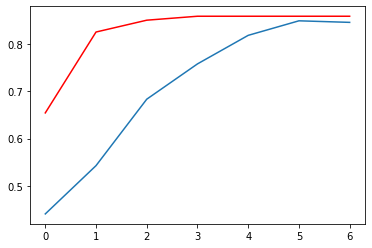

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0.0, 7.0, 1.0), train_acc_list, np.arange(0.0, 7.0, 1.0), test_acc_list, 'r-')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# 새로운 문장 테스트
def predict(predict_sentence):
  data = [predict_sentence, '0']
  dataset_another = [data]

  another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
      token_ids = token_ids.long().to(device)
      #print("token_ids : ", token_ids)
      segment_ids = segment_ids.long().to(device)
      #print("segment_ids : ", segment_ids)

      valid_length= valid_length
      #print("valid_length : ", valid_length)
      label = label.long().to(device)
      #print("label : ", label)
      out = model(token_ids, valid_length, segment_ids)

      #print("out : ", out)

      test_eval=[]
      for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()
          logits = softmax(logits)
          print("softmax : ", logits)

          if np.argmax(logits) == 0:
                test_eval.append("유용x")
          elif np.argmax(logits) == 1:
                test_eval.append("유용")
        

      print(">> 이 리뷰는 " + test_eval[0] + "합니다.")

      print(">> 이 리뷰는 " + str(int(logits[1]*100)) + "%정도 유용합니다.")
      return logits[1]

using cached model


In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("리뷰를 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")

리뷰를 입력해주세요 : 너무 사용하기편리하고 텁텁한 느낌도없이 정말 깔금하고 좋습니다.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


softmax :  [0.6303159  0.36968407]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 36%정도 유용합니다.


리뷰를 입력해주세요 : **어성초가 피부에 잘 맞는 사람임**  토너랑 앰플은 아누아에서 썼어가지고 어제 올리브영 가자마자 기획세트 팔길래 바로 득템했어요! 그런데 제가 사자마자 완전 할인하네요ㅠ 원래 토너 하나에 3만원 돈인데 토너에다가 앰플 공짜로 주는데도 3만원밖에 안되길래 산건데..허허😢 일단 쟁여놓으려고 하나 더 구매할 예정입니다! 지금 사신 분들 진짜 부럽네요🏆🏆  무튼 리뷰 작성 시작합니다!  어릴 때부터 민감하다고 생각했던 피부인데도 토너는 5통 넘게 거의 1년 가까이 사용하고 있고 앰플도 몇 개월 동안 3통 공병 만들면서 싹싹 쓰고 있는데요.   🌈피부 타입! 사진보면 아시겠지만 뭐 하나 잘못 바르기만 하면 바로 빨갛게 올라오고 저는 볼이랑 입주변에 주로 좁쌀이 올라오고 이마에는 가끔 올라오는 피부였어요. 약간 민감하면서 좁쌀도 올라오는데 또 건조해서 주름도 잘 지는 그런 피부..?ㅎㅎ  🌈사용방법! 제가 사용한 방법은 토너팩입니다. 아누아에서 화장솜도 파는데 그게 진짜 좋거든요. 거기에 밤마다 토너 듬뿍 적셔가지고 올려둔 담에 10분 정도 있다가 떼고 앰플 스포이드 가득 한 번 바르면 촉촉해요. 자고 일어나면 이런게 진정이구나를 알 수 있는 저만의 치트키입니다🔥  🌈장점! 제 기준 순한 성분 1등! 제가 이렇게 오랫동안 쓸 수 있었던 이유는 순한 성분이기 때문인 것 같은데요! 77토너가 딱 피부에 맞아서 계속 사용해오다 보니까 다른 제품쓰려고 시도해도 약간 간지러운 느낌이 들더라구요ㅠㅠㅠ 저한텐 이게 자극처럼 느껴져서 금방 다시 77토너로 돌아왔어요. 토너는 또 화장솜에 묻혀서 쓰다보니까 아무래도 성분적으로 순한게 중요하다고 생각하거든요!💪💪 그런점에서 아누아 어성초 라인 전체는 저한테 정말 보물이에요. 순해가지고 언제 어디서 사용해도 피부가 편하고 진정돼서 좋거든요!  🌈또 장점! 수분이랑 진정! 토너는 클

KeyboardInterrupt: ignored

In [ ]:
# 데이터셋 불러오기
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/데캡디/review_data_1700_1217.csv')
df.head()

,review,label
0,온 가족이 쓰는 수분크림입니다. 발림성이 좋고 피부에 자극없어서 자주 애용합니다.,0
1,추천추천추천합니다 순해서 자극없고 발림성도 좋아요 수분감도 좋은것같아 맘에듭니다^^,0
2,세안하고나서 수건으로 얼굴의 물기를 닦아내지않고 바로 토너를 사용하고 있어서 저한텐...,0
3,샘플사용해보고 좋아서 본품 구매햇어요 수분크림역할 잘하는 거 같아요 다만 용기가 불...,0
4,수부지 수분크림으로 유명하고 20ml증정해주고 세일해서 구매했어요 아직 사용은안했지...,0


In [ ]:
score_list = []

for i in range(len(df)):
    temp = df.iloc[i]['review']
    score_list.append(predict(temp))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


softmax :  [0.5852896  0.41471037]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 41%정도 유용합니다.
softmax :  [0.8245297  0.17547028]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 17%정도 유용합니다.
softmax :  [0.31928438 0.6807156 ]
>> 이 리뷰는 유용합니다.
>> 이 리뷰는 68%정도 유용합니다.
softmax :  [0.83136714 0.16863288]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 16%정도 유용합니다.
softmax :  [0.8194416  0.18055843]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 18%정도 유용합니다.
softmax :  [0.33449852 0.6655015 ]
>> 이 리뷰는 유용합니다.
>> 이 리뷰는 66%정도 유용합니다.
softmax :  [0.81784487 0.18215513]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 18%정도 유용합니다.
softmax :  [0.33292744 0.6670726 ]
>> 이 리뷰는 유용합니다.
>> 이 리뷰는 66%정도 유용합니다.
softmax :  [0.32479605 0.675204  ]
>> 이 리뷰는 유용합니다.
>> 이 리뷰는 67%정도 유용합니다.
softmax :  [0.5651308  0.43486923]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 43%정도 유용합니다.
softmax :  [0.34239474 0.6576053 ]
>> 이 리뷰는 유용합니다.
>> 이 리뷰는 65%정도 유용합니다.
softmax :  [0.6042348 0.3957652]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 39%정도 유용합니다.
softmax :  [0.8026619  0.19733816]
>> 이 리뷰는 유용x합니다.
>> 이 리뷰는 19%정도 유용합니다.
softmax :  [0.8064057 0.1935943]
>> 이 리뷰는 유용x

In [ ]:
df['score'] = score_list

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  1578 non-null   object 
 1   label   1578 non-null   int64  
 2   score   1578 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.1+ KB


In [ ]:
df_score = df.sort_values(by=['score'], axis=0, ascending=False)

In [ ]:
df_score['review'].iloc[0]

'기존에 새로 산 토너가 너무 안 맞아서 급하게 세일하는 토너 아무거나 산 게 신의 한 수였습니다....너무 좋아요..... 음....일단 진정 효과는 잘 모르겠으나 (토너 단계 제품만으로 드라미틱한 진정효과를 바라는 게 무리일수도...??) 이 토너는 정말 제가 딱 원하던 수분감이에요. 제가 한 겨울에도 유분 폭발하는 파워 지성인데 그래도 토너 단계를 통해 기초적인 수분을 채워주지 않으면 속건조로 인한 트러블이 생기더라구요. 근데 이 제품으로 양볼에 2방울씩 떨어트려서 2번 레이어드 해주면 저같은 지성피부에게 속보습 채워주고 겉도 촉촉한 딱 적당한 수분감입니다. 물처럼 흐르는 타입이라 끈적임 없는 것도 너무 좋고 건성이신 분들에게는 부족할 수 있는 수분감이지만 복합성까지는 딱 적당한 수분감이에요. 어차피 토너 단계 이후에 다들 앰플이나 보습제 바르니까요...?? 대용량 나오면 더더욱 좋겠지만 그래도 저는 계속 재구매 의사 있습니다!! 복합성부터 지성까지 토너 한번 바꿔볼까?? 생각 하시고 계신 분들 한 번 써보시는 거 추천드려요!! '

In [ ]:
df_score['review'].iloc[1]

'티존은 유분이 있는 지성피부이고 볼은 중성 정도의 피부입니다 예전에 닥터지 수딩 수분크림? 사용했는데 볼이랑 눈쪽이 땡기는 거 같아서 복합성을 고려하여 이 제품 사봤어요  먼저 사용감이 산뜻하고 수분이 있는 게 느껴질 만큼 수부지피부에게 좋은 제품인 거 같아요 복합성인 제 피부에도 잘 맞았고 티존 또한 유분을 조절해주는 토너와 사용하니 유분도 잘 안 나와서 좋았습니다  파운데이션이랑도 궁합이 좋은 거 같았고  쿨링감은 느껴지진 않았어요  진정에 도움이 된다기보단 수분충전용으로 잘 사용할 듯해요 같이 온 패드도 좋은 거 같아요 성분도 좋아서 걱정없이 사용할 수 있었고 티존에 사용할시엔 유분이 올라오더라고요 볼만 사용했을 때는 정말 수분이 충전되는 느낌이에요 진정효과는 제가 원래 트러블 피부가 아니여서 잘은 모르겠지만..열감을 낮춰주면서 붉은기가 가라앉는 거 같아요!!'

In [ ]:
df_score['review'].iloc[2]

'👉🏻 1. 민감성 피부에 좋습니다 피부가 예민하신 분은 어성초 77토너를 한 번 써보세요 무자극이여서 순하고 왠만한 예민 피부엔 잘 맞을 것 같습니다.   👉🏻2. 홍조 있으신분! 기획세트에 솜까지 같이 와서 토너를 묻혀서 볼에 두시면 진정효과가 있어요 제가 홍조가 심한 편인데 붉은끼가 조금 가라앉았어요.  👉🏻3. 토너의 제형이 물 같아요 그래서 요새 닦토 많이 하시던데 저는 닦토를 하면 피부트러블이 더 나는 것 같아서 다이소에 분사식 스프레이 공병을 사서 요 안에 넣고 뿌리는 형식으로 씁니다. 피부 민감한 분들은 이렇게 해보시면 피부에 더 자극없이 사용하실 수 있어요.  👉🏻4. 무향이에요 토너는 제 개인적은 의견이지만 향기로운 냄새 나는 건 뭔가 성분 자체에 첨가가 많이 된 것 같은 느낌이라 선호하지 않아요 요건 무향이라 더 건강한 토너 느낌이 나요!'

In [ ]:
df_score['review'].iloc[3]

'아누아 어성초 77 수딩토너 🌿 💦  어성초가 피부진정이나 염증에 좋다고 들어서 구매했습니다. 앰플은 이미 사용하는 제품이 있어서 토너 제형인 어성초 77 수딩토너로 선택했어요.   수부지에 마스크 때문에 턱 위주로 트러블이 가끔 올라오는 피부입니다. 유분이 많을 때는 닦토로 사용하고, 평소에는 그냥 흡토로 사용하니까 딱 좋았습니다.   물토너라 유분감은 없고, 그렇다고 흡토한 뒤에 막 건조하지도 않아서 사계절 내내 닦토, 흡토, 토너팩으로 두루두루 잘 사용할 수 있을 것 같아요!   작은 트러블 올라왔을 때 토너팩 해주면 다음날 많이 가라앉아있어요. 어성초 함량이 높고 전성분이 순해서인지 진정효과가 좋은 것 같습니다.   그리고 각질 관리에도 도움이 되는 것 같아요. 평소처럼 일주일에 두세 번 오일클렌징 하는 것 제외하고는 따로 한 게 없는데 평소보다 부드러운 느낌입니다.'

In [ ]:
df_score['review'].iloc[4]

'아누아 어성초 패드 사용해보고 너무 만족스러워서 스킨도 구매했어요 어성초 성분이 잘 안 맞을 수도 있어서 본인에게 적합한지 작은 용량 먼저 써보고 구매하는게 좋을 것 같아요 수분부족형 지성에 마스크로 작은 트러블들이 자꾸 생겨서 고민이었는데 진정시키는데 효과가 좋아요 제형은 묽은 토너 느낌이고 깔끔하게 마무리되는 편이라 닦토로 사용하기 좋아요! 저는 주로 닦토로 쓰고 공병에 덜어 미스트 대용으로도 자주 뿌려줍니다 트러블이 진정되는데 확실이 보이고 피부결 정돈에 너무 좋아여 ㅠㅠ 유명한데는 이유가 있구나 싶습니다 향은 무난한 풀떼기 향이예요 강하지 않아서 호불호가 갈리지는 않을 거예요 세일하는 가격에 여행용사이즈, 화장솜까지 패키지로 받아서 만족합니다 화장솜도 촵촵 잘 먹고 스킨팩하기 딱 좋아요 재구매 의사있습니다!'

In [ ]:
df_score.head()

,review,label,score
1556,기존에 새로 산 토너가 너무 안 맞아서 급하게 세일하는 토너 아무거나 산 게 신의 ...,1,0.699595
1516,티존은 유분이 있는 지성피부이고 볼은 중성 정도의 피부입니다 예전에 닥터지 수딩 수...,1,0.698486
1084,👉🏻 1. 민감성 피부에 좋습니다 피부가 예민하신 분은 어성초 77토너를 한 번 써...,1,0.698265
1473,아누아 어성초 77 수딩토너 🌿 💦 어성초가 피부진정이나 염증에 좋다고 들어서 구...,1,0.697749
1336,아누아 어성초 패드 사용해보고 너무 만족스러워서 스킨도 구매했어요 어성초 성분이 잘...,1,0.697715


In [ ]:
df_score['review'].iloc[-5]

'순하고 트러블안나고 자극없고  예민한 수부지 피부인 저한테 잘 맞앗어요  향은 무향이에요  기름기없는 수분크림 넘 조아요 '

In [ ]:
df_score['review'].iloc[-4]

'선크림에 들어있던 샘플 써보고 구매했어요 순하고 자극없이 좋아요 지성피부가 써도 기름지지도 않고 만족스러워요 '

In [ ]:
df_score['review'].iloc[-3]

'전에는 항상 토너패드를 썼었는데 이번엔 진짜 심기일전하고 피부 좋아져보자하고 이 토너를 사봤는데 진짜 좋은것 같아요. 향도 무향이고 좋아요'

In [ ]:
df_score['review'].iloc[-2]

'얼마써보지않아 효과는 엄청 보지못했지만 대용량!!좋다고 소문난 제품이어서 믿고 써보겠습니다'

In [ ]:
df_score['review'].iloc[-1]

'하도 유명하기도 하고 피부가 당기고 아주 난리도 아니라서 한번 구매했습니다. 이번에 어워즈덕분에 더 저렴한 가격으로 구매해서 기분이 좋네요. 너무 리치하지 않아서 집안에 두고 간간히 잘 바를 것 같아요 '

In [ ]:
df_score.to_csv('/content/drive/MyDrive/데캡디/df_score.csv')